In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks");

!pip install diffrax
!pip install orthojax --upgrade
!pip install py-design --upgrade

  Using cached diffrax-0.4.1-py3-none-any.whl.metadata (3.7 kB)
Using cached diffrax-0.4.1-py3-none-any.whl (161 kB)
  Attempting uninstall: diffrax
    Found existing installation: diffrax 0.6.0
    Uninstalling diffrax-0.6.0:
      Successfully uninstalled diffrax-0.6.0

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip


# Uncertainty Propagation in Dynamical Systems

Consider the following $n$ dimensional dynamical system:

$$
\dot{\mathbf{x}} = \mathbf{f}(t,\mathbf{x};\boldsymbol{\Xi}),
$$

where $\mathbf{x} \in \mathbb{R}^n$ is the state vector, $\mathbf{f}$ is a vector valued function, $t$ is time, and $\Xi$ is a vector of uncertain parameters.
The initial condition is:

$$
\mathbf{x}(0) = \mathbf{x}_0(\boldsymbol{\Xi}).
$$

We assume that:

$$
\boldsymbol{\Xi} = (\Xi_1,\dots,\Xi_d),
$$

independent. 
The goal is to propagate the uncertainty in $\boldsymbol{\Xi}$ through the system to obtain the uncertainty in $\mathbf{x}$.

The space we work with is:

$$
L^2(\mathbf{\Xi},\mathbb{R}^n) = \left\{\mathbf{g}:\mathbb{R}^d\to\mathbb{R}^n\mid \int_{\mathbb{R}^d} \|\mathbf{g}(\boldsymbol{\Xi})\|^2\,d\boldsymbol{\Xi} < \infty\right\},
$$

with inner product:

$$
\langle \mathbf{g},\mathbf{h}\rangle = \int_{\mathbb{R}^d} \mathbf{g}(\boldsymbol{\Xi})\cdot\mathbf{h}(\boldsymbol{\Xi})\,d\boldsymbol{\Xi}.
$$

Let $\{\phi_\alpha\}$ be the tensor product orthonormal basis for $L^2(\mathbf{\Xi})$ and $\{\mathbf{e}_i\}$ be the standard basis for $\mathbb{R}^n$.
Then, the functions:

$$
\boldsymbol{\psi}_{i,\alpha} = \mathbf{e}_i\phi_\alpha,
$$

form an orthonormal basis for $L^2(\mathbf{\Xi},\mathbb{R}^n)$.

We expand the dynamical system state in this basis (at each time):

$$
\mathbf{x}(t;\Xi) = \sum_{i=1}^n \sum_{\alpha} \mathbf{x}_{i,\alpha}(t)\boldsymbol{\psi}_{i,\alpha}(\boldsymbol{\Xi}).
$$

We plug this into the dynamical system to get:

$$
\dot{\mathbf{x}}(t;\Xi) = \sum_{i=1}^n \sum_{\alpha} \dot{\mathbf{x}}_{i,\alpha}(t)\boldsymbol{\psi}_{i,\alpha}(\boldsymbol{\Xi})
= \mathbf{f}\left(t,\sum_{i=1}^n \sum_{\alpha} \mathbf{x}_{i,\alpha}(t)\boldsymbol{\psi}_{i,\alpha}(\boldsymbol{\Xi});\boldsymbol{\Xi}\right).
$$

We project each side onto $\psi_{j,\beta}$ and use the orthogonality of the basis to get:

$$
\dot{\mathbf{x}}_{j,\beta}(t) = \left\langle \mathbf{f}\left(t,\sum_{i=1}^n \sum_{\alpha} \mathbf{x}_{i,\alpha}(t)\psi_{i,\alpha}(\boldsymbol{\Xi});\boldsymbol{\Xi}\right),\boldsymbol{\psi}_{j,\beta}\right\rangle.
$$

This is a differential equation that describes the evolution of the coefficients $\mathbf{x}_{i,\alpha}(t)$.
The initial condition is:

$$
\mathbf{x}_{i,\alpha}(0) = \left\langle \mathbf{x}_0(\boldsymbol{\Xi}),\boldsymbol{\psi}_{i,\alpha}\right\rangle.
$$

Let's write `jax` code that solves this problem.

In [2]:
from collections import namedtuple

import orthojax as ojax
import design
import jax.numpy as jnp
from jax import vmap, jit


def make_sparse_grid(dim, level):
    """Make a sparse grid of dimension dim and a given level.
    We do it for the uniform cube [-1, 1]^d."""
    x, w = design.sparse_grid(dim, level, 'F2')
    w = w / (2 ** dim)
    x = jnp.array(x, dtype=jnp.float32)
    w = jnp.array(w, dtype=jnp.float32)
    return ojax.QuadratureRule(x, w)


PCProblem = namedtuple("PCProblem", ["poly", "quad", "f", "x0", "phis", "y0", "rhs"])


def make_pc_problem(poly, quad, f, x0):
    """Make the PC dynamical system problem.

    Params:
        poly: The polynomial basis
        quad: The quadrature rule used to compute inner products
        f: The function defining the right hand side of the ODE (function of x, t and xi) to R^n
        x0: The initial condition (function of xi, from R^d -> R^n)
        theta: The parameters of the ODE
    """
    # The quadrature rule used to compute inner products
    xis, ws = quad
    # xis is m x d and ws is m

    # The polynomial basis functions on the collocation points
    phis = poly(xis)
    # this is m x p

    # The initial condition of the PC coefficients
    x0s = jit(vmap(x0))(xis) # this is m x n
    # The PC coefficients are n x p
    # ws is m
    # phis is m x p
    # x0s is m x n
    # y0 must be n x p
    y0 = jnp.einsum("m,mp,mn->np", ws, phis, x0s)
    
    # Vectorize the function f
    fv = vmap(f, in_axes=(None, 0, 0))
    
    # The right hand side of the PC ODE
    def rhs(t, y, phis):
        # y is n x p
        # phis is m x p
        # xs must be m x n
        xs = jnp.einsum("np,mp->mn", y, phis)
        # xs is m x n
        # xis is m x d
        # fs must be m x n
        fs = fv(t, xs, xis)
        # do the dot product with quadrature weights
        return jnp.einsum("m,mn,mp->np", ws, fs, phis)
    
    return PCProblem(poly, quad, f, x0, phis, y0, rhs)

## Example: Duffing Oscillator with Random Initial State

$$\begin{align}
\dot{x} & = v \\
\dot{v} & = \gamma \cos(\omega t) - \delta v - \alpha x - \beta x^3,
\end{align}$$

With initial state:

$$
x(0) \sim N(\mu_x, \sigma_x^2), \quad v(0) \sim N(\mu_y, \sigma_v^2).
$$

We are going to keep the parameters $\alpha,\beta,\gamma,\delta, \omega$ fixed and only vary the initial state.

The first thing we are going to do is express the initial conditions in terms of independent random variables $\Xi_1,\Xi_2 \sim U[-1,1]$.
This will allow us to use Legendre polynomials.
Let $\Phi$ be the CDF of the standard normal distribution.
Then:

$$
x(0) = \mu_x + \sigma_x \Phi^{-1}\left((\Xi_1 + 1) / 2\right),
\quad v(0) = \mu_v + \sigma_v \Phi^{-1}\left((\Xi_2 + 1) / 2\right).
$$

We are going to develop both a Monte Carlo solver and a polynomial chaos solver.
But first, let's get a bit organized.
We are going to create some useful named tuples to hold the parameters and the initial conditions.

In [3]:
import equinox as eqx
from collections import namedtuple

NormalDistribution = namedtuple("NormalDistribution", ["mu", "sigma"])
Parameters = namedtuple("Parameters", ["alpha", "beta", "gamma", "delta", "omega"])

Duffing = namedtuple("Duffing", ["params", "X", "V"])

These can be used as follows:

In [4]:
X = NormalDistribution(0.0, 0.1)
V = NormalDistribution(0.0, 0.1)

params = Parameters(1.0, 5.0, 0.37, 0.1, 1.0)

duffing = Duffing(params, X, V)

Here is how they appear:

In [5]:
print(duffing)

Duffing(params=Parameters(alpha=1.0, beta=5.0, gamma=0.37, delta=0.1, omega=1.0), X=NormalDistribution(mu=0.0, sigma=0.1), V=NormalDistribution(mu=0.0, sigma=0.1))


This is, of course, a `pytree` and it will help us write functions with not so many arguments.

Now, let's write code that implements the initial conditions and vector field:

In [6]:
from jax.scipy import stats as jstats
from functools import partial
from diffrax import diffeqsolve, Tsit5, SaveAt, ODETerm


def to_normal(xi : float, dist : NormalDistribution) -> float:
    """Transforms a [-1, 1] to a normal distribution."""
    return dist.mu + dist.sigma * jstats.norm.ppf(0.5 * (xi + 1))

def x0(xi, duffing : Duffing):
    """Initial condition for the position."""
    return jnp.array(
        [to_normal(xi[0], duffing.X), to_normal(xi[1], duffing.V)]
    )

def vector_field(t, y, params):
    x = y[0]
    v = y[1]
    alpha = params.alpha
    beta = params.beta
    gamma = params.gamma
    delta = params.delta
    omega = params.omega
    return jnp.array(
        [
            v,
            - alpha * x - beta * x ** 3 - delta * v + gamma * jnp.cos(omega * t)
        ]
    )

@jit
@partial(vmap, in_axes=(0, None))
def solve_duffing(xi, duffing : Duffing):
    """Simple solver of the dynamical system."""
    solver = Tsit5()
    saveat = SaveAt(ts=jnp.linspace(0, 10, 2000))
    term = ODETerm(vector_field)
    sol = diffeqsolve(
        term,
        solver,
        t0=0,                       
        t1=10,                      
        dt0=0.1,                    
        y0=x0(xi, duffing),
        args=duffing.params,
        saveat=saveat
    )
    return sol.ys

Develop the Monte Carlo ground truth:

In [7]:
import numpy as np

num_samples = 100_000
xis = 2 * np.random.uniform(size=(num_samples, 2)) - 1
samples = solve_duffing(xis, duffing)

mc_mean = jnp.mean(samples, axis=0)
mc_var = jnp.var(samples, axis=0)

Now, let's write a polynomial chaos solver. First, construct the polynomials and the quadrature rule:

In [8]:
from functools import partial

total_degree = 5
degrees = (5, 5)
poly = ojax.TensorProduct(
    total_degree,
    [ojax.make_legendre_polynomial(d) for d in degrees])
level = 5
quad = make_sparse_grid(2, level)

Now, make the polynomial chaos solver:

In [130]:
new_vector_field = lambda t, x, xi: vector_field(t, x, duffing.params)
new_x0 = lambda xi: x0(xi, duffing)
pc_problem = make_pc_problem(poly, quad, new_vector_field, new_x0)

In [131]:
@jit
def solve_duffing_pc(duffing, poly=poly, quad=quad):
    # Adhere to the PCProblem interface
    new_vector_field = lambda t, x, xi: vector_field(t, x, duffing.params)
    new_x0 = lambda xi: x0(xi, duffing)
    pc_problem = make_pc_problem(poly, quad, new_vector_field, new_x0)
    sol = diffeqsolve(
        ODETerm(pc_problem.rhs),
        Tsit5(),
        t0=0,
        t1=10,
        dt0=0.1,
        y0=pc_problem.y0,
        args=pc_problem.phis,
        saveat=SaveAt(ts=jnp.linspace(0, 10, 2000))
    )
    return sol

And now we can solve it as follows:

In [132]:
pc_sol = solve_duffing_pc(duffing)

Let's calculate the mean and the variance of PC:

In [133]:
pc_mean = pc_sol.ys[:, :, 0]
pc_variance = np.sum(pc_sol.ys[:, :, 1:] ** 2, axis=2)

Let's compare the Monte Carlo solution with the polynomial chaos solution:

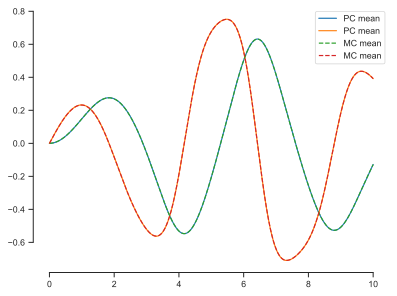

In [134]:
fig, ax = plt.subplots()
ax.plot(pc_sol.ts, pc_mean, label="PC mean")
ax.plot(pc_sol.ts, mc_mean, '--', label="MC mean")
ax.legend(loc="best")
sns.despine(trim=True);

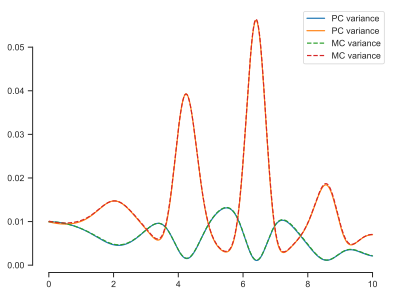

In [135]:
fig, ax = plt.subplots()
ax.plot(pc_sol.ts, pc_variance, label="PC variance")
ax.plot(pc_sol.ts, mc_var, '--', label="MC variance")
ax.legend(loc="best")
sns.despine(trim=True);

This looks perfect!

Of course, if you increase the initial variance, the polynomial chaos solution will be less accurate.
You can experiment with this.

Let me demonstrate that the polynomial chaos solution is much faster than the Monte Carlo solution.
This will take a while to run.

In [136]:
# write code that times the PC solver and the MC solver
%timeit solve_duffing_pc(duffing)
%timeit solve_duffing(xis, duffing)

5.01 ms ± 29.2 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
5.19 s ± 184 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Much faster.

Finally, let me demonstrate an added benefit of the PC solution.
It can be used as a surrogate for the solution of the dynamical system.
This means that you can evaluate the solution at any $\xi$ without having to solve the dynamical system.
Here is how:

In [137]:
@jit
def surrogate(xis, pc_coeff=pc_sol.ys, poly=poly):
    """Surrogate function for the PC solution."""
    phis = poly(xis)
    ys = jnp.einsum("tip,mp->mti", pc_coeff, phis)
    return ys

Let's evaluate both the surrogate and the solution at a bunch of points and compare them:

In [138]:
num_test = 2
xis_test = 2 * np.random.uniform(size=(num_test, 2)) - 1
preds = surrogate(xis_test)
true = solve_duffing(xis_test, duffing)

Compare the two:

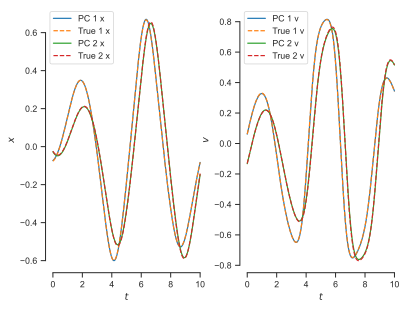

In [139]:
names = ["x", "v"]
fig, ax = plt.subplots(1, 2)
for i in range(num_test):
    for k in range(2):
        ax[k].plot(pc_sol.ts, preds[i, :, k], label=f"PC {i+1} {names[k]}")
        ax[k].plot(pc_sol.ts, true[i, :, k], '--', label=f"True {i+1} {names[k]}")
        ax[k].legend(loc="best")
        ax[k].set_xlabel("$t$")
        ax[k].set_ylabel("$" + names[k] + "$")
    plt.legend(loc="best")
sns.despine(trim=True);

You can use this surrogate to do all sorts of things, like getting higher order statistics, the PDF, or the [Sobol indices](https://en.wikipedia.org/wiki/Variance-based_sensitivity_analysis) with respect to $\Xi$.